<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/cnn/practical_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Image Recognition

* Data Loading taken from: https://keras.io/examples/vision/image_classification_from_scratch/

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 Laptop GPU (UUID: GPU-d83ce678-672f-f772-a847-ff0cf97190db)


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# in case we do not want GPU
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [7]:
# https://github.com/AndreasMadsen/python-lrcurve
import sys

if 'google.colab' in sys.modules:
  !pip install -q lrcurve

In [8]:
# https://github.com/keisen/tf-keras-vis
# https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb

if 'google.colab' in sys.modules:
  !pip install -q tf-keras-vis

In [9]:
from lrcurve import KerasLearningCurve

# Step I: Get and Explore data

In [12]:
if 'google.colab' in sys.modules:
    !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  6826k      0  0:01:57  0:01:57 --:--:-- 7047k


In [18]:
if 'google.colab' in sys.modules:
    !unzip -oq kagglecatsanddogs_3367a.zip

In [19]:
!ls -l PetImages

total 0
drwxrwxrwx 1 olli olli 4096 Feb 10  2017 Cat
drwxrwxrwx 1 olli olli 4096 Feb 10  2017 Dog


In [21]:
!ls -l PetImages/Cat | head -5

total 408420
-rwxrwxrwx 1 olli olli   12213 Feb 10  2017 0.jpg
-rwxrwxrwx 1 olli olli   16868 Feb 10  2017 1.jpg
-rwxrwxrwx 1 olli olli   35381 Feb 10  2017 10.jpg
-rwxrwxrwx 1 olli olli   30725 Feb 10  2017 100.jpg
ls: write error: Broken pipe


In [22]:
!ls -l PetImages/Dog | head -5

total 487304
-rwxrwxrwx 1 olli olli    34448 Feb 10  2017 0.jpg
-rwxrwxrwx 1 olli olli    26799 Feb 10  2017 1.jpg
-rwxrwxrwx 1 olli olli    36637 Feb 10  2017 10.jpg
-rwxrwxrwx 1 olli olli    24746 Feb 10  2017 100.jpg
ls: write error: Broken pipe


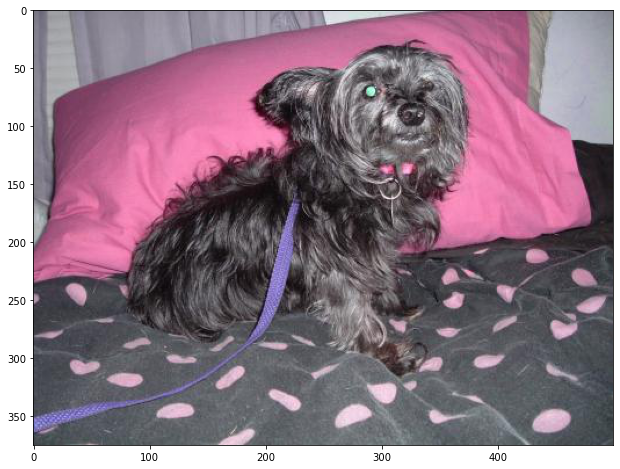

In [23]:
from skimage import io

sample = 'PetImages/Dog/0.jpg'
image = io.imread(sample)
plt.imshow(image);

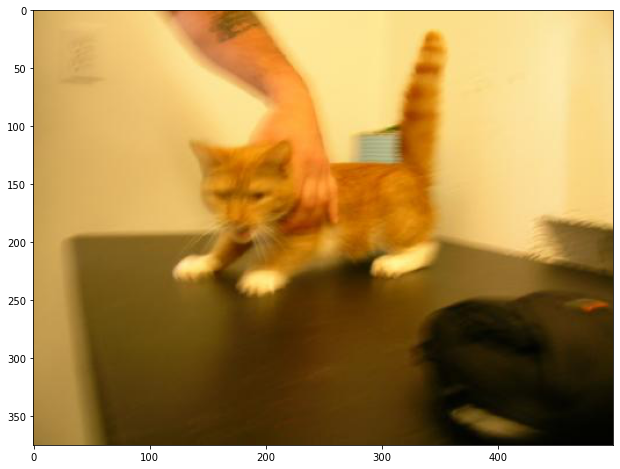

In [24]:
sample = 'PetImages/Cat/0.jpg'
image = io.imread(sample)
plt.imshow(image);

In [25]:
image.shape

(375, 500, 3)

In [26]:
image.shape[0] / image.shape[1]

0.75

In [27]:
import os

num_valid = 0
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        else:
            num_valid += 1


print(f'Deleted {num_skipped} images, keeping {num_valid}')

KeyboardInterrupt: 

# Step II: Prepare data for training

* we need training data and at least one test/validation set
* realistic datasets are too big to keep in memory
* need to stream them
* keras has some nice helper libraries for that
  * helper just saves some work, but does nothing too fancy
  * you can also build this from scratch: https://www.tensorflow.org/guide/data


In [20]:
# tf.keras.preprocessing.image_dataset_from_directory?

In [21]:
x_size = 75
y_size = 100
image_size = (y_size, x_size)
# image_size = (180, 180)
batch_size = 32
seed=1337

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [22]:
image_batch, label_batch = next(iter(train_ds))
image_batch.shape, label_batch.shape

(TensorShape([128, 100, 75, 3]), TensorShape([128]))

In [23]:
image = image_batch[0]
image.shape

TensorShape([100, 75, 3])

In [24]:
import numpy as np

image_np = image.numpy()
image_np.dtype

dtype('float32')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


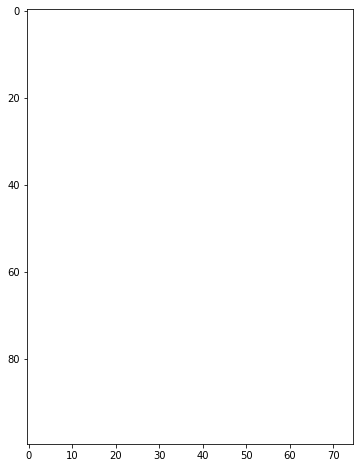

In [25]:
plt.imshow(image_np);

In [26]:
np.min(image_np), np.max(image_np)

(24.756409, 255.0)

In [27]:
# plt.hist(np.unique(image));

In [28]:
image_np = image_np / 255.0
np.min(image_np), np.max(image_np)

(0.097083956, 1.0)

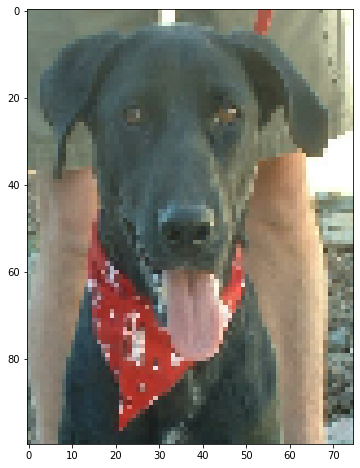

In [29]:
plt.imshow(image_np);

In [30]:
label_names = ['Cat', 'Dog']

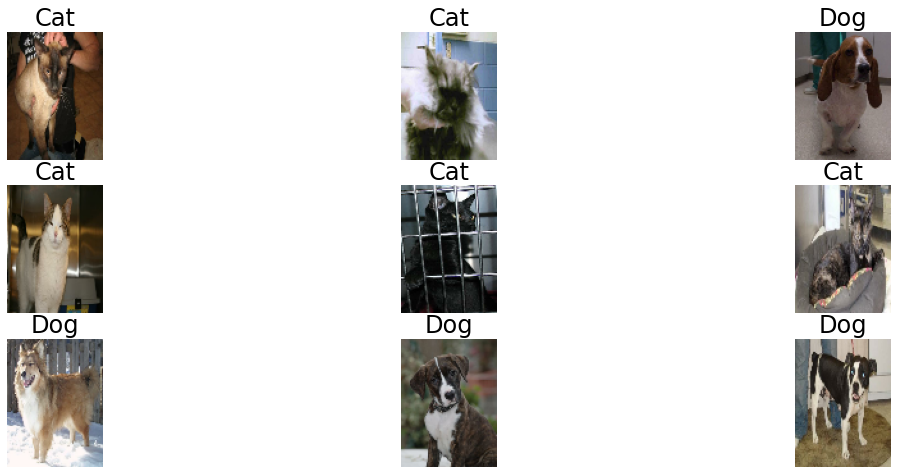

In [31]:
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label_names[int(labels[i])])
        plt.axis("off")

# Step III: Training

In [32]:
# network takes float anyway and likes values close to 0
# we could bring this into GPU processing by making it a TF function
normalized_train_ds = train_ds.map(lambda image, label: (image / 255.0, label))
normalized_val_ds = val_ds.map(lambda image, label: (image / 255.0, label))

In [33]:
input_shape=(y_size, x_size, 3)
num_classes = 2

In [34]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

model = tf.keras.Sequential()

model.add(Input(shape=input_shape))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu')) 
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 74, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 37, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 49, 37, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 49, 37, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 36, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 18, 64)       0

In [35]:
%%time

epochs = 15

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
history = model.fit(
    normalized_train_ds, 
    validation_data=normalized_val_ds,
    epochs=epochs,
    callbacks=[KerasLearningCurve()],
    verbose=0)

CPU times: user 9min 1s, sys: 2min 32s, total: 11min 33s
Wall time: 8min 50s


# Step IV: Evaluation

In [36]:
train_loss, train_accuracy = model.evaluate(normalized_train_ds)
train_accuracy

147/147 [==============================] - 17s 107ms/step - loss: 0.0349 - accuracy: 0.9870


0.9870247840881348

In [37]:
test_loss, test_accuracy = model.evaluate(normalized_val_ds)
test_accuracy

37/37 [==============================] - 4s 87ms/step - loss: 0.9743 - accuracy: 0.7937


0.7936779260635376

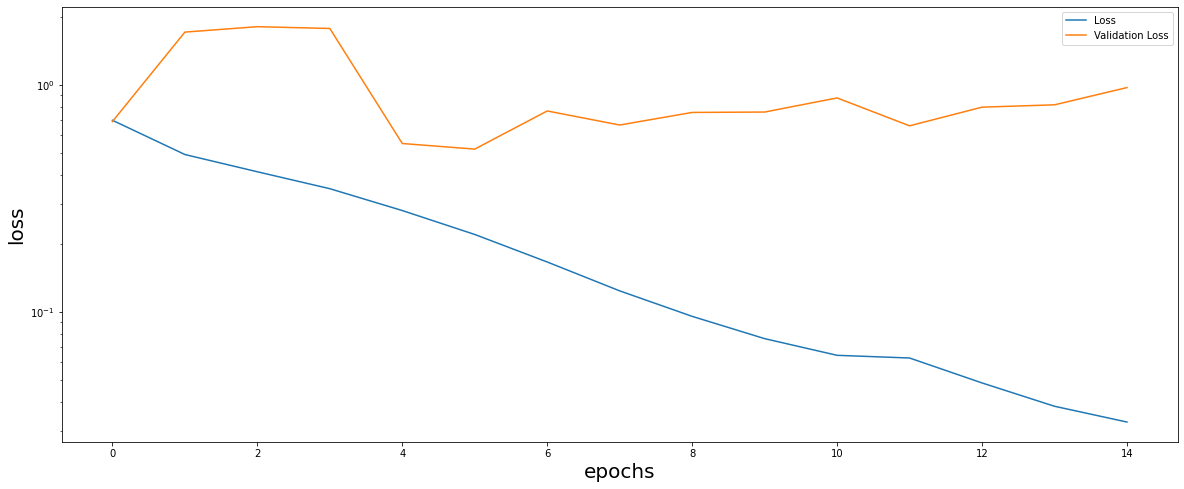

In [38]:
plt.xlabel('epochs')
plt.ylabel('loss')

plt.yscale('log')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss']);

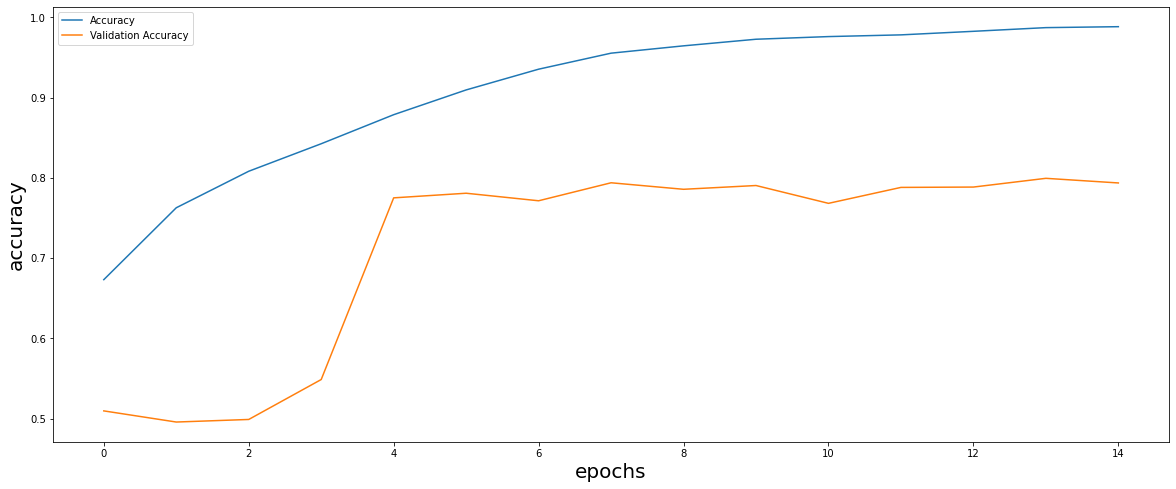

In [39]:
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Validation Accuracy']);

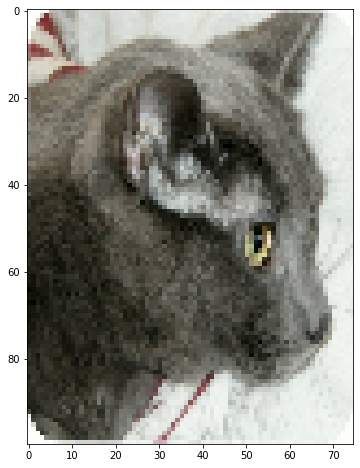

In [40]:
img = tf.keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
) 
plt.imshow(img);

In [41]:
CAT = 0
DOG = 1

# be careful, networks fail silently, don't forget to normalize to 0..1
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(f'This image is {100 * score[CAT]} percent cat and {100 * score[DOG]} percent dog.')

This image is 99.51819777488708 percent cat and 0.4817953333258629 percent dog.


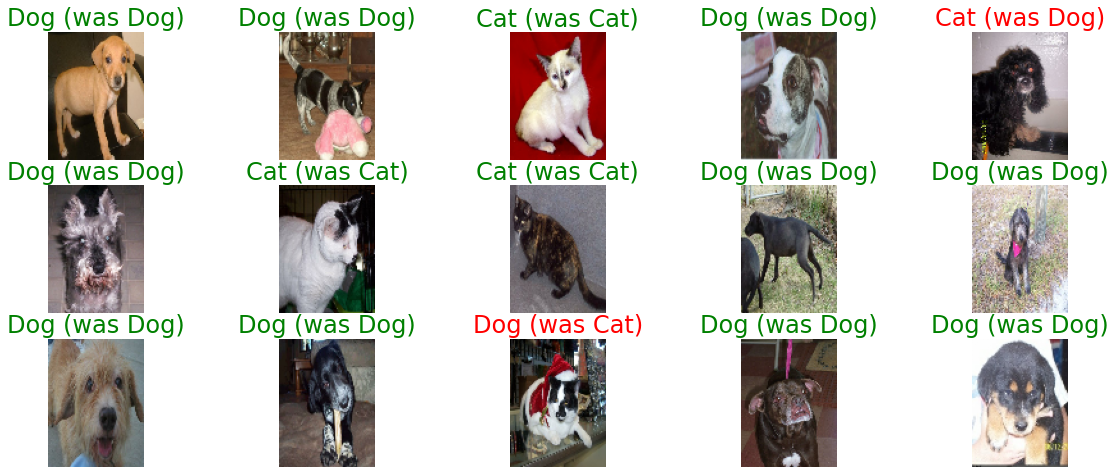

In [42]:
for images, labels in normalized_val_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        image = images[i]
        y_true = labels[i]
        y_pred = model.predict(tf.expand_dims(image, 0)).argmax(axis=1)[0]
        plt.imshow(images[i])
        plt.title("{} (was {})".format(label_names[y_pred], 
                                  label_names[y_true]),
                                  color=("green" if y_pred == y_true else "red"))
        plt.axis("off")

# Step V: Deterministic Evaluation

In [76]:
# tf.keras.preprocessing.image_dataset_from_directory?

In [87]:
# need this to be deterministic as we need y_pred and y_true to be aligned
deterministic_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=1024,
    shuffle=True
).map(lambda image, label: (image / 255.0, label))

Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [88]:
val_image_batch, val_label_batch = next(iter(deterministic_val_ds))
val_image_batch.shape, val_label_batch.shape

(TensorShape([1024, 100, 75, 3]), TensorShape([1024]))

In [89]:
# would also work on dataset
y_pred = model.predict(val_image_batch).argmax(axis=1)

In [93]:
y_pred.shape

array([1, 0, 1, ..., 1, 0, 0])

In [91]:
y_pred[:10]

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1])

In [92]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([509, 515]))

In [94]:
# also possible on dataset
# y_true = np.concatenate(list(deterministic_val_ds.map(lambda image, label: label).as_numpy_iterator()))
y_true = val_label_batch.numpy()

In [95]:
y_true.shape

(1024,)

In [96]:
np.unique(y_true, return_counts=True)

(array([0, 1], dtype=int32), array([480, 544]))

In [97]:
y_true[:10]

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1], dtype=int32)

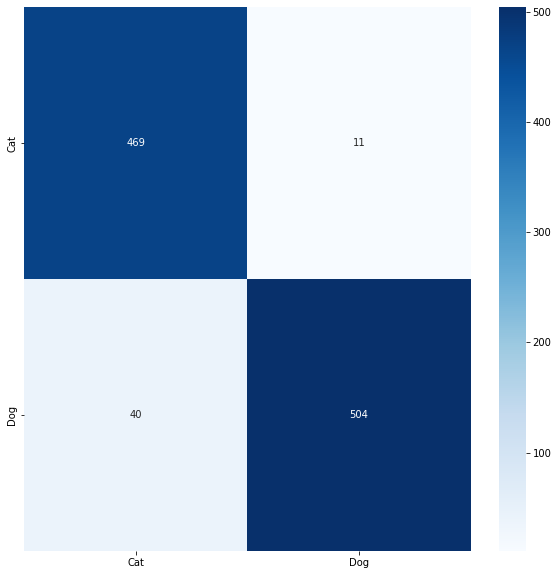

In [99]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
figure = plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Blues', fmt='d')


# Step V: Introspection

In [50]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

from tensorflow.keras import backend as K

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m


def plot_map(X, y, index, map_only=False):
    image = X[index]
    label = y[index]

    saliency_images = np.array([image], dtype='float32')
    
    def input_output_mapping(output):
        return (output[0][label])
    
    saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)

    saliency_map = saliency(input_output_mapping, saliency_images)
    saliency_map = normalize(saliency_map)
    
    if map_only:
      plt.imshow(saliency_map[0], cmap='jet')
    else:
      plt.imshow(image);
      plt.imshow(saliency_map[0], cmap='jet', alpha=0.3);


In [50]:
for images, labels in deterministic_val_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        image = images[i]
        y_true = labels[i]
        y_pred = model.predict(tf.expand_dims(image, 0)).argmax(axis=1)[0]
        plt.imshow(images[i])
        plt.title("{} (was {}), index: {}".format(label_names[y_pred], 
                                  label_names[y_true]),
                                  color=("green" if y_pred == y_true else "red"),
                                  i)
        plt.axis("off")